In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt

In [3]:
import os 
for dirname, _, filenames in os.walk('/Users/Chabi/Desktop/santander-customer-transaction-prediction'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/Users/Chabi/Desktop/santander-customer-transaction-prediction/test.csv
/Users/Chabi/Desktop/santander-customer-transaction-prediction/05_xgboost_scores.csv
/Users/Chabi/Desktop/santander-customer-transaction-prediction/train.csv
/Users/Chabi/Desktop/santander-customer-transaction-prediction/sample_submission.csv


In [5]:
input_dir = '/Users/Chabi/Desktop/santander-customer-transaction-prediction/'
df_train = pd.read_csv(input_dir + 'train.csv')
df_train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [6]:
# zmienne zaleznie i niezalezne
var_columns = [c for c in df_train.columns if c not in ['ID_code', 'target']]

X = df_train.loc[:, var_columns]
y = df_train.loc[:, 'target']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# stworzenie prostego GB modelu
model_gbm = GradientBoostingClassifier(n_estimators=5000,
                                      learning_rate=0.05,
                                      max_depth=3,
                                      subsample=0.5,
                                      validation_fraction=0.1,
                                      n_iter_no_change=20,
                                      max_features='log2',
                                      verbose=1)
model_gbm.fit(X_train, y_train)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.6500           0.0010           14.06m
         2           0.6460           0.0013           13.92m
         3           0.6388           0.0008           13.93m
         4           0.6487           0.0008           13.85m
         5           0.6403           0.0008           13.87m
         6           0.6465           0.0008           13.95m
         7           0.6393           0.0015           13.83m
         8           0.6416           0.0007           13.83m
         9           0.6374           0.0011           13.81m
        10           0.6376           0.0013           13.79m
        20           0.6347           0.0010           13.68m
        30           0.6207           0.0005           13.59m
        40           0.6048           0.0007           13.56m
        50           0.6022           0.0008           13.50m
        60           0.5957           0.0005           13.47m
       

GradientBoostingClassifier(learning_rate=0.05, max_features='log2',
                           n_estimators=5000, n_iter_no_change=20,
                           subsample=0.5, verbose=1)

In [8]:
# ile drzew model stworzyl
len(model_gbm.estimators_)

1669

In [11]:
# sprawdzenie dopasowania 
y_train_pred = model_gbm.predict_proba(X_train)[:,1]
y_valid_pred = model_gbm.predict_proba(X_valid)[:,1]

print('AUC Train: {:.4f}\nAUC Valid: {:.4f}'.format(roc_auc_score(y_train, y_train_pred),
                                                   roc_auc_score(y_valid, y_valid_pred)))

AUC Train: 0.9291
AUC Valid: 0.8943


In [12]:
# zbadanie jak zmienia sie dopasowanie przy konkretnej liczbie drzew
y_train_pred_trees = np.stack(list(model_gbm.staged_predict_proba(X_train)))[:,:,1]
y_valid_pred_trees = np.stack(list(model_gbm.staged_predict_proba(X_valid)))[:,:,1]

y_train_pred_trees.shape, y_valid_pred_trees.shape

((1669, 160000), (1669, 40000))

In [13]:
auc_train_trees = [roc_auc_score(y_train, y_pred) for y_pred in y_train_pred_trees]
auc_valid_trees = [roc_auc_score(y_valid, y_pred) for y_pred in y_valid_pred_trees]

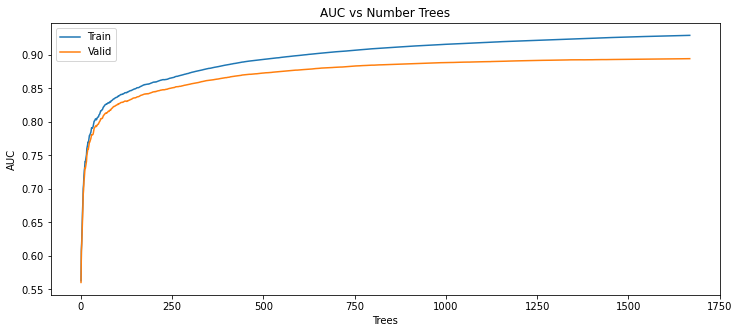

In [15]:
# wykres wyjasnienia
plt.figure(figsize=(12, 5))

plt.plot(auc_train_trees, label='Train')
plt.plot(auc_valid_trees, label='Valid')

plt.title('AUC vs Number Trees')
plt.ylabel('AUC')
plt.xlabel('Trees')
plt.legend()

plt.show()

In [25]:
# zbadanie istotnosci zmiennych
pd.DataFrame({'Variable_Name': var_columns,
             'Importance': model_gbm.feature_importances_})\
            .sort_values('Importance', ascending=False)

,Variable_Name,Importance
81,var_81,0.028986
12,var_12,0.020840
139,var_139,0.020776
53,var_53,0.018470
6,var_6,0.017517
...,...,...
100,var_100,0.000427
17,var_17,0.000386
129,var_129,0.000376
185,var_185,0.000283


In [18]:
# zaladowanie testowych danych i sampli 
df_test = pd.read_csv(input_dir + 'test.csv')
df_sample_submission = pd.read_csv(input_dir + 'sample_submission.csv')

df_test.shape, df_sample_submission.shape

((200000, 201), (200000, 2))

In [19]:
# predykcja prawdopodobienstwa
X_test = df_test.loc[:, var_columns]

df_sample_submission['target'] = model_gbm.predict_proba(X_test)[:,1]
df_sample_submission

,ID_code,target
0,test_0,0.084446
1,test_1,0.213509
2,test_2,0.185043
3,test_3,0.111020
4,test_4,0.048138
...,...,...
199995,test_199995,0.047854
199996,test_199996,0.006569
199997,test_199997,0.004506
199998,test_199998,0.095129


In [21]:
# zapisanie jako csv
output_dir = '/Users/Chabi/Desktop/santander-customer-transaction-prediction/'
df_sample_submission.to_csv(output_dir +'03_gbm_scores', index=False)